In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
dev = 'cpu'
import math
# Cool resources about autoregressive models
# https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
# https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling

# Autoregressive modeling

$N$ dimensional input with lag $P$.

$\hat{y}_t = f(y_{t-1},y_{t-2},...,y_{t-P})$

We can model this with a fully connected layer

\begin{equation}
X_t | X_{i<t} = \theta_0 + \sum^P_{i=i}{\theta_i X_{t-i}}
\end{equation}

And the whole system as a DNN with nonlinearity $\delta(.)$ at the $l^{th}$ layer:

\begin{equation}
H^l_t = \sigma(\Theta^{l-1}_t\cdot H_t^{l-1})
\end{equation}

# Limitations of fully connected layers
#### 1. **Training** with linear layers is inefficient as autoregressive value needs to be computed for every possible window of size $P$.

This means that we don't have weight preloading strategies like in the case of CNNs. To generate an output in a CNN, we compute the intermediate outputs of a layer for all the sequence before computing the next one. This means that we can implement training un-rolling (since we know the future data points at train time) and avoid computing a single forward pass for every input before processing next one. 

A CNN that implements **casual** processing of inputs is called TCN.

#### 2. The number of weights grows linearily with the receptive field of the model. For multi-time scale models (speech, audio) this becomes quickly an issue.

Fully connected layers don't have implemented downsampling methods such as dilation or stride that would increase receptive field without increasing the number of parameters.

# A harmonic series dataset

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [9]:
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(harmonics*torch.sin(self.phases))
        return sample

Let's generate a dataset and plot its content.

240
240


/tools/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


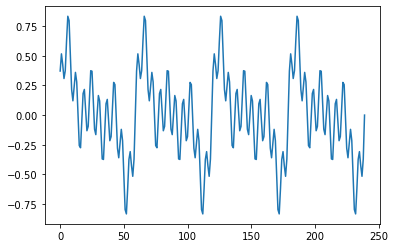

In [10]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)
samples = torch.zeros(signal_len)

for i,sample in enumerate(dataloader):
    samples[i] = sample
fig, ax = plt.subplots()
ax.plot(samples.detach().numpy())
plt.show()

# A simple forecasting problem.

Let's generate a dataset for the models to predict an output $A$ samples ahead.

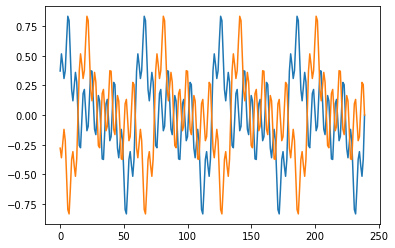

In [24]:
A = 15
train_samples = samples.unsqueeze(0).unsqueeze(0)
test_samples = torch.roll(train_samples,A,2)

plt.show()

fig, ax = plt.subplots()
ax.plot(train_samples.view(-1).detach().cpu().numpy())
ax.plot(test_samples.view(-1).detach().cpu().numpy())
plt.show()

# Autoregressive MLP module

In [5]:
class autoregressiveMLP(nn.Module):
    def __init__(self,in_size,seq_len,hidden_layers,hidden_size,device,use_bias = True):
        super().__init__()
        
        total_in_size = in_size * seq_len
        out_size = in_size
        net = []
        if(hidden_layers == 0):
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
            #net.append(nn.Tanh())
        else:
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            for i in range(hidden_layers):
                net.append(nn.Linear(hidden_size,hidden_size,bias=use_bias))
                net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
            #net.append(nn.Tanh()) # Works better with identity for the toy example
        
        self.net = nn.Sequential(*net)

    '''
    Updates circular buffer with new item and process output
    The model predicts x_n from a collection of previous entries.
    Forward process:
        circular buffer contains all prev samples in this order: 
        [x_{n-1} , x_{n-2}, ... , x_{n-P}]
        1. Predict next output from current collection of prev samples.
        2. Update buffer with either current sample or force the correct value.
        3. Return prediction
    
        I think this is wrong
        # Roll and detach previous grad (otherwise it computes all grads through time)
            self.seq = torch.roll(self.seq,1,0).detach()
            self.seq[0,:] = item
            #print(self.seq.view(-1))
            return self.net(self.seq.view(-1))
    
    '''
    def forward(self,seq):
        ''' 

        '''
        #print("net input: {}".format(self.seq.view(-1)))
        pred = self.net(seq.view(-1))
        return pred

# Training and Evaluation function

In [23]:
def mlp_evaluate(net,P,train_samples,target,device,plot=False):

    seq = torch.zeros([P]).to(device)
    train_samples = train_samples.to(device).view(-1)
    target = target.to(device).view(-1)
    predictions = torch.zeros_like(target)
    with torch.no_grad():
        for i, sample in enumerate(train_samples):
            seq = torch.roll(seq,1,0)
            seq[0] = sample
            seq.detach()
            pred = net(seq)
            predictions[i] = pred
            
    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().numpy())
        ax.plot(predictions.detach().numpy())
        plt.show()
    return eval_loss

def mlp_evaluate_autoregressive(net,A,P,train_data,target,device,section=0.5,plot=False):

    seq = torch.zeros([P]).to(device)
    target = target.to(device).view(-1)
    train_data = train_data.to(device).view(-1)
    predictions = torch.zeros_like(train_data)
    target_len = len(train_data)
    l1 = int(target_len*section)
    l2 = target_len - l1
    
    with torch.no_grad():
        for i in range(l1):
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = train_data[i].to(device)# Teacher forcing
            seq.detach()

        for i in range(l2):
            predictions[l1 + i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[l1 + i - A] # Feed back A-old output (so that it forecasts the next one)
            seq.detach()
            
            #fig, ax = plt.subplots()
            #ax.plot(seq.detach().numpy())
            #plt.show()
            
    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[AUTOREGRESSIVE TEST] Forecasting after {} - eval loss {}".format(section,eval_loss))        
        ax.plot(target.detach().numpy())
        ax.plot(predictions.detach().numpy())
        plt.show()
    return eval_loss

    
def mlp_train(net,A,P,epochs,train_samples,target,device,teacher_force = False):
    net.train()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    best_eval_loss = np.inf
    train_samples = train_samples.to(device).view(-1)
    target = target.to(device).view(-1)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data        

        for i, sample in enumerate(train_samples):
            optimizer.zero_grad()
            seq = torch.roll(seq,1,0)
            seq[0] = sample
            seq.detach()            
            prediction = net(seq)

            loss = criterion(prediction, target[i].unsqueeze(0))
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()


        eval_loss = mlp_evaluate_autoregressive(net,A,P,train_samples,target,device,section=0.5)
        #eval_loss = mlp_evaluate(net,P,train_samples,target,device)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(net.state_dict(), 'best_mlp.pt')
            
        if(epoch % 50 == 0): 
            #fig, ax = plt.subplots()
            #ax.plot(net.seq.detach().numpy())
            #plt.show()
            print("[EPOCH {}] train loss {} - best eval {}".format(epoch,running_loss,best_eval_loss))
        running_loss = 0.0

    print('Finished Training')


# Training the MLP

We train the model to forecast $A$ samples ahead. 
After training is complete, we perform an autoregressive test.

1. We feed the model some training sequence, with the model giving output.

1. Then, at some point, we feed just feed the output back to the input.

I believe we may not have to `.detach()` the circular buffer for every new sample we input, this way we would be able to effectively backpropagate through time. Problem is, this constructs very complex gradient trees.

In [7]:
def train_and_test_MLP(A,P,hidden_size,n_hidden_layers,train_data,target,epochs,device,eval_section=0.5):
    train_len = train_data.size()[2]
    in_size = 1
    
    net = autoregressiveMLP(in_size,P,n_hidden_layers,hidden_size,device)
    net = net.to(device)

    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("[INFO] Number of parameters: {}".format(params))
    teacher_force = True
    mlp_train(net,A,P,epochs,train_data,target,device,teacher_force)
    
    net.load_state_dict(torch.load('best_mlp.pt'))
    net.eval()
    mlp_evaluate(net,P,train_data,target,device,plot=True)
    
    mlp_evaluate_autoregressive(net,A,P,train_data,target,device,section=0.5,plot=True)



[INFO] Number of parameters: 6433
[EPOCH 0] train loss 49.041728999465704 - best eval 53.57508087158203
[EPOCH 50] train loss 8.994889253750443 - best eval 50.17816162109375
Finished Training
[TEST ON DATA] eval loss 16.04690170288086


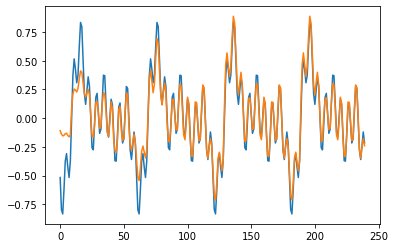

[AUTOREGRESSIVE TEST] Forecasting after 0.5 - eval loss 50.17816162109375


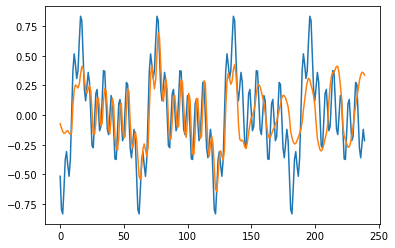

In [8]:
train_and_test_MLP(A,100,32,3,train_samples,test_samples,epochs=100,device=dev,eval_section=0.5)

[INFO] Number of parameters: 3873
[EPOCH 0] train loss 52.65691096521914 - best eval 61.97380828857422
[EPOCH 50] train loss 12.551706086611375 - best eval 56.90651321411133
Finished Training
[TEST ON DATA] eval loss 14.643011093139648


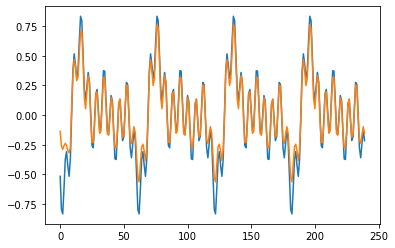

[AUTOREGRESSIVE TEST] Forecasting after 0.5 - eval loss 56.90651321411133


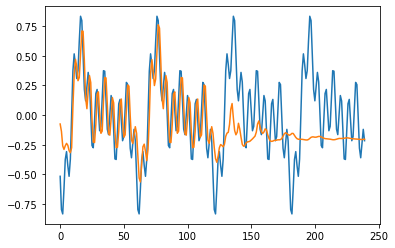

In [9]:
train_and_test_MLP(A,20,32,3,train_samples,test_samples,epochs=100,device=dev,eval_section=0.5)

[INFO] Number of parameters: 3553
[EPOCH 0] train loss 64.5497179524973 - best eval 60.839752197265625
[EPOCH 50] train loss 7.719132244819775 - best eval 53.33914566040039
Finished Training
[TEST ON DATA] eval loss 29.228267669677734


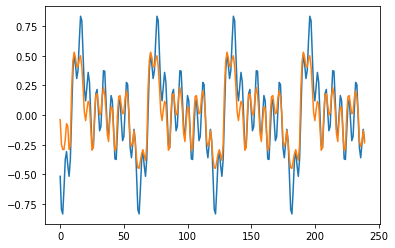

[AUTOREGRESSIVE TEST] Forecasting after 0.5 - eval loss 53.33914566040039


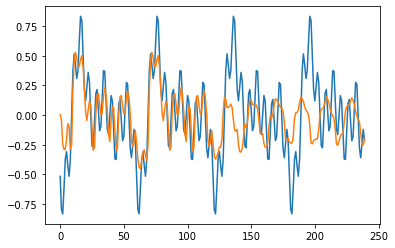

In [10]:
train_and_test_MLP(A,10,32,3,train_samples,test_samples,epochs=100,device=dev,eval_section=0.5)

[INFO] Number of parameters: 51073
[EPOCH 0] train loss 68.52749435720034 - best eval 64.86322021484375
[EPOCH 50] train loss 10.515223172085825 - best eval 58.631500244140625
Finished Training
[TEST ON DATA] eval loss 21.22542953491211


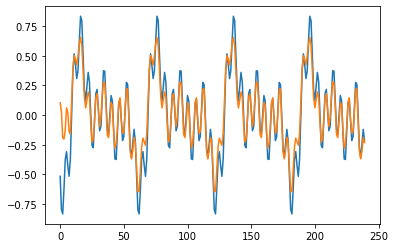

[AUTOREGRESSIVE TEST] Forecasting after 0.5 - eval loss 58.631500244140625


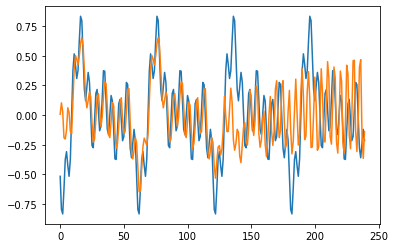

In [11]:
train_and_test_MLP(A,10,128,3,train_samples,test_samples,epochs=100,device=dev,eval_section=0.5)

# TCN: Temporal Convolutional Network

## Causal convolution layer
To obtain a causal conv layer, we have to add zero-padding to the left. The amount of padding needed depends of the kernel size $k$ and dilation factor $b$.

\begin{equation}
p = b \cdot (k-1)
\end{equation}

We create a class inheriting from `torch.nn.Conv1d` and apply only left padding to the input.

In [25]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True,
                 apply_padding=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.apply_padding = apply_padding
        self.__padding = dilation*(kernel_size - 1)
        
    def forward(self, input):
        # Apply left padding using torch.nn.functional and then compute conv.
        if(self.apply_padding):
            return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))
        else:
            return super(CausalConv1d, self).forward(input)

## TCN Residual Block

A causal convolutional layer will output the same sequence length as the input one. The TCN Residual block also outputs the same length. But, even though we have an output sequence the same size as the input one, this does not guarantee that we will take into account a specific sequence coverage. Therefore, the last question that remains is how to ensure **full sequence coverage**.

Full sequence coverage means that the receptive field is big enough to address the full desired sequence length we have to take into account.

<img src="https://unit8.com/wp-content/uploads/2021/07/image-49.png" width="600">

Image source: https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

In [26]:
class TCN_block(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,kernel_size,stride=1,dilation=1,apply_padding=True,last_block=False):
        super().__init__()
        block = []
        cnv1 = CausalConv1d(in_channels,hidden_channels,kernel_size,stride=stride,dilation=dilation,apply_padding=apply_padding)
        block.append(torch.nn.utils.weight_norm( cnv1 ) )
        block.append(nn.ReLU())
        block.append(nn.Dropout())
        
        cnv2 = CausalConv1d(hidden_channels,out_channels,kernel_size,stride=stride,dilation=dilation,apply_padding=apply_padding)
        block.append(torch.nn.utils.weight_norm( cnv2 ) )
        if(last_block == False):
            block.append(nn.ReLU())
            block.append(nn.Dropout())
        
        self.block = nn.Sequential(*block)
        
        #self.residual = nn.Conv1d(in_channels,out_channels,1,padding = 0,stride=stride)
    
    def forward(self,data):
        block_out = self.block(data)
        #residual = self.residual(data)
        #print("block_out {} - residual {}".format(block_out.size(),residual.size()))
        #return block_out + residual
        return block_out

## TCN Network

The receptive field of a TCN with $n$ blocks, kernel size of $k$, and dilation base of $b$ is given by:
\begin{equation}
r = 1 + 2 \cdot (k-1) \cdot \frac{b^n-1}{b-1}
\end{equation}

Given a desired coverage $l$ of the input, a dilation base $b$, and a kernel size base of $k \geq b$, the number of residual block $n$ required to guarantee the coverage is given by:
\begin{equation}
n = log_b(\frac{(l-1)\cdot(b-1)}{(k-1) \cdot 2} + 1)
\end{equation}

In [27]:
class TCN_net(nn.Module):
    def __init__(self,n_blocks,in_channels,hidden_channels,out_channels,kernel_size,dilation_base,apply_padding=True):
        super().__init__()
        base = 0
        net = []

        net.append(TCN_block(in_channels,hidden_channels,hidden_channels,kernel_size,dilation=dilation_base**base,apply_padding=apply_padding))
        if(n_blocks>2):
            for i in range(n_blocks-2):
                base += 1
                net.append(TCN_block(hidden_channels,hidden_channels,hidden_channels,kernel_size,dilation=dilation_base**base,apply_padding=apply_padding))
        
        base += 1
        net.append(TCN_block(hidden_channels,hidden_channels,out_channels,kernel_size,dilation=dilation_base**base,apply_padding=apply_padding,last_block=True))

        self.net = nn.Sequential(*net)
    
    def forward(self,in_sequence):
        return self.net(in_sequence)


# Training the TCN

In [28]:
def tcn_evaluate_on_data(net,eval_data,target,device,plot=False):
    with torch.no_grad():
        eval_data = eval_data.to(device)
        predictions = net(eval_data)

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.view(-1).detach().numpy())
        ax.plot(predictions.view(-1).detach().numpy())
        plt.show()
    return eval_loss

def tcn_train(net,epochs,train_data,target,device):
    net.train()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    best_eval_loss = np.inf
    #   If I declare the buffer here, then it will have signal present at the
    #   beggining of all epochs except epoch 0. It will be more difficult 
    #   for the model to kickstart its prediction cause it does not overfit 
    #   to the case where it has all zeroes and starts predicting from scratch.
    
    #seq = torch.zeros([P]).to(device)
    train_data = train_data.to(device)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        optimizer.zero_grad()
        # forward + backward + optimize
        prediction = net(train_data)

        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()


        #eval_loss = evaluate_dry(net,P,samples,device)
        eval_loss = tcn_evaluate_on_data(net,train_data,target,device)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(net.state_dict(), 'best_tcn.pt')

        if(epoch % 1000 == 0 and epoch != 0): 
            eval_loss = tcn_evaluate_on_data(net,train_data,target,device,plot=True)
            
        if(epoch % 100 == 0 and epoch != 0): 
            #fig, ax = plt.subplots()
            #ax.plot(net.seq.detach().numpy())
            #plt.show()
            print("[EPOCH {}] train loss {} - best eval {}".format(epoch,running_loss,best_eval_loss))
            #net.eval()

            #evaluate_on_train_data(net,target)
            
            #net.train()
        running_loss = 0.0

    print('Finished Training')

In [29]:
def train_and_test_TCN(n_blocks,in_channels,hidden_channels,out_channels,kernel_size,dilation_base,train_data,target,epochs,device):

    net = TCN_net(n_blocks,in_channels,hidden_channels,out_channels,kernel_size,dilation_base)
    net = net.to(device)
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("[INFO] Number of parameters: {}".format(params))
    tcn_train(net,epochs,train_data,target,device)
    
    tcn_evaluate_on_data(net,train_data,target,device,plot=True)

## TCN Training


Receptive field: 13.0
N_layers : 2
[INFO] Number of parameters: 6530
[EPOCH 100] train loss 0.1892831027507782 - best eval 40.25649642944336
[EPOCH 200] train loss 0.16244791448116302 - best eval 37.38536071777344
[EPOCH 300] train loss 0.145567387342453 - best eval 33.48759460449219
[EPOCH 400] train loss 0.13989117741584778 - best eval 31.11257553100586
[EPOCH 500] train loss 0.15195855498313904 - best eval 31.015207290649414
[EPOCH 600] train loss 0.14651064574718475 - best eval 28.986766815185547
[EPOCH 700] train loss 0.1325998604297638 - best eval 28.22873878479004
[EPOCH 800] train loss 0.15134547650814056 - best eval 26.880144119262695
[EPOCH 900] train loss 0.13230068981647491 - best eval 26.880144119262695
[TEST ON DATA] eval loss 27.722991943359375


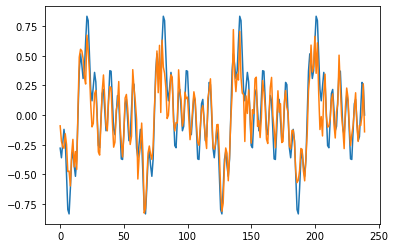

[EPOCH 1000] train loss 0.12748853862285614 - best eval 26.33875846862793
[EPOCH 1100] train loss 0.11560568958520889 - best eval 25.183666229248047
[EPOCH 1200] train loss 0.12462294846773148 - best eval 23.72748565673828
[EPOCH 1300] train loss 0.11454416066408157 - best eval 23.72748565673828
[EPOCH 1400] train loss 0.10261546820402145 - best eval 23.72748565673828
[EPOCH 1500] train loss 0.10800140351057053 - best eval 23.72748565673828
[EPOCH 1600] train loss 0.1122594028711319 - best eval 23.72748565673828
[EPOCH 1700] train loss 0.1197742149233818 - best eval 23.201194763183594
[EPOCH 1800] train loss 0.0963544100522995 - best eval 22.582971572875977
[EPOCH 1900] train loss 0.10841425508260727 - best eval 22.582971572875977
Finished Training
[TEST ON DATA] eval loss 26.58664321899414


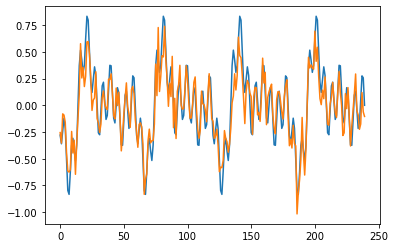

In [30]:
dilation_base = 2
kernel_size = 3
n_blocks = 2
dilation_factor = (dilation_base**n_blocks-1)/(dilation_base-1)
P = 1 + 2*(kernel_size-1)*dilation_factor
print("Receptive field: {}".format(P))

arg = ( (P-1)*(dilation_base-1) )/( (kernel_size-1)*2 )
n = int(math.log(arg, dilation_base) + 1)
print("N_layers : {}".format(n))

train_and_test_TCN(n_blocks,1,32,1,kernel_size,dilation_base,train_data=train_samples,target=test_samples,epochs=2000,device=dev)

We have trained a TCN to predict values ahead of time.
When running this model on real-time, we don't have all the collection of past, present, and future samples.
Different than during the training / evaluation process, we now want to run this model in a sample-by-sample basis, where each layer is executed once per input. 

Knowing the receptive field of this network, we then know the size of the circular buffer we need to manage to run this net sample-by-sample. A circular buffer of receptive field $r$ will yield just one sample at the end of the network.

In [31]:
print("Receptive field is: {}".format(P))
net = TCN_net(n_blocks,1,32,1,kernel_size,dilation_base,apply_padding=False)
net.load_state_dict(torch.load('best_tcn.pt'))
net.eval()
b = torch.zeros(int(P)).unsqueeze(0).unsqueeze(0)
print("Input size: {}".format(b.size()))
print("Output size: {}".format(net(b).size()))

Receptive field is: 13.0
Input size: torch.Size([1, 1, 13])
Output size: torch.Size([1, 1, 1])


# Sample-by-sample inference

On a real-time scenario, we don't have a predefined collection of samples to perform inference from. Therefore we need to run this TCN from data stored in a **circular buffer**.

In order to do so, we deactivate the padding of the network; we want it to predict a single value from our circular buffer. This explicits memory management by the application, furthermore, we don't have to run a bigger input sequence just to take the last value of it.

1. We will run a common execution of the padded TCN, exactly as it was trained.

1. Then, we will re-load the TCN with padding deactivated, and we will test it against a circular buffer implementation of size $r$.

In [54]:
def tcn_evaluate_sample_by_sample(net,P,train_samples,target,device,plot=False):

    seq = torch.zeros([P]).to(device).unsqueeze(0).unsqueeze(0)
    train_samples = train_samples.to(device).view(-1)
    target = target.to(device).view(-1)
    predictions = torch.zeros_like(target)
    with torch.no_grad():
        for i, sample in enumerate(train_samples):
            seq = torch.roll(seq,-1,2) # We roll it counterclock-wise for TCN.     
            seq[0,0,-1] = sample # And we load it at the last position of the circular buffer.
            pred = net(seq)
            predictions[i] = pred.squeeze(0).squeeze(0)
            
    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().numpy())
        ax.plot(predictions.detach().numpy())
        plt.show()
    return eval_loss

[TEST ON DATA] eval loss 11.7484130859375


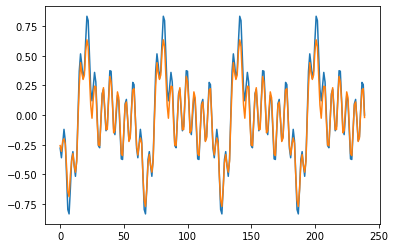

[TEST ON DATA] eval loss 13.13474178314209


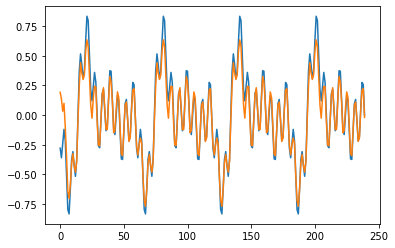

tensor(13.1347)

In [55]:
# Load padded TCN and test on train data
net = TCN_net(n_blocks,1,32,1,kernel_size,dilation_base,apply_padding=True)
net.load_state_dict(torch.load('best_tcn.pt'))
net.eval()
tcn_evaluate_on_data(net,train_samples,test_samples,device=dev,plot=True)

# Load unpadded TCN and test on train data
net = TCN_net(n_blocks,1,32,1,kernel_size,dilation_base,apply_padding=False)
net.load_state_dict(torch.load('best_tcn.pt'))
net.eval()
tcn_evaluate_sample_by_sample(net,int(P),train_samples,test_samples,device=dev,plot=True)